# 02. Baseline CNN Model

## Introduction
This notebook implements a custom Convolutional Neural Network (CNN) from scratch for anomaly detection. 
It is fully self-contained and includes:
1. Data Loading & Preprocessing
2. Model Architecture Definition
3. Training Loop
4. Evaluation

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")

2025-11-24 00:53:14.911910: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 00:53:15.161871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/mathieu/Works/Projet-PIC/.venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/mathieu/Works/Projet-PIC/.venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major

TensorFlow Version: 2.20.0


## 1. Configuration & Data Loading
We define hyperparameters and load the dataset directly from the `data/raw` directory.

In [2]:
import sys
sys.path.append('..')
from src.preprocessing.dataset import load_and_split_data

# Hyperparameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DATA_DIR = "../data/raw"
TARGET_CATEGORY = 'capsule' # Train only on this category

# Load data using the new preprocessing function (Per-Category)
print(f"Loading and splitting data for {TARGET_CATEGORY}...")
train_df, val_df, test_df, class_names = load_and_split_data(DATA_DIR, target_category=TARGET_CATEGORY, augment=True)

print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Loading and splitting data for capsule...
Classes: ['capsule_crack', 'capsule_faulty_imprint', 'capsule_good', 'capsule_poke', 'capsule_scratch', 'capsule_squeeze']
Number of classes: 6
Training samples: 280
Validation samples: 35
Test samples: 36


In [3]:
import tensorflow as tf

def process_path(filepath, label):
    # Load the raw data from the file as a string
    img = tf.io.read_file(filepath)
    # Decode and convert to grayscale/color
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    # Resize the image to the desired size
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, label

def create_dataset(dataframe, batch_size=32, shuffle=False):
    # Create a dataset from the dataframe
    filepaths = dataframe['filepath'].values
    labels = dataframe['label'].values
    
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    # Map the process_path function
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE

# Create datasets
train_ds = create_dataset(train_df, BATCH_SIZE, shuffle=True)
val_ds = create_dataset(val_df, BATCH_SIZE, shuffle=False)
test_ds = create_dataset(test_df, BATCH_SIZE, shuffle=False)

print("Datasets created successfully.")

Datasets created successfully.


2025-11-24 00:53:49.347925: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Model Architecture
We define a custom CNN with Convolutional blocks, Batch Normalization, and Dropout.

In [4]:
def create_cnn_custom(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Rescaling [0, 255] -> [0, 1]
    x = layers.Rescaling(1./255)(inputs)
    
    # Block 1
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # Block 2
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # Block 3
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # Dense
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name="cnn_custom")
    return model

model = create_cnn_custom((IMG_HEIGHT, IMG_WIDTH, 3), len(class_names))
model.summary()

Model: "cnn_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,430 (435.27 KB)

 Trainable params: 110,982 (433.52 KB)

 Non-trainable params: 448 (1.75 KB)

## 3. Training
We compile and train the model.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

## 4. Evaluation
Visualizing loss curves and confusion matrix.

In [ ]:
# Plot History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

2025-11-23 23:48:16.791589: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


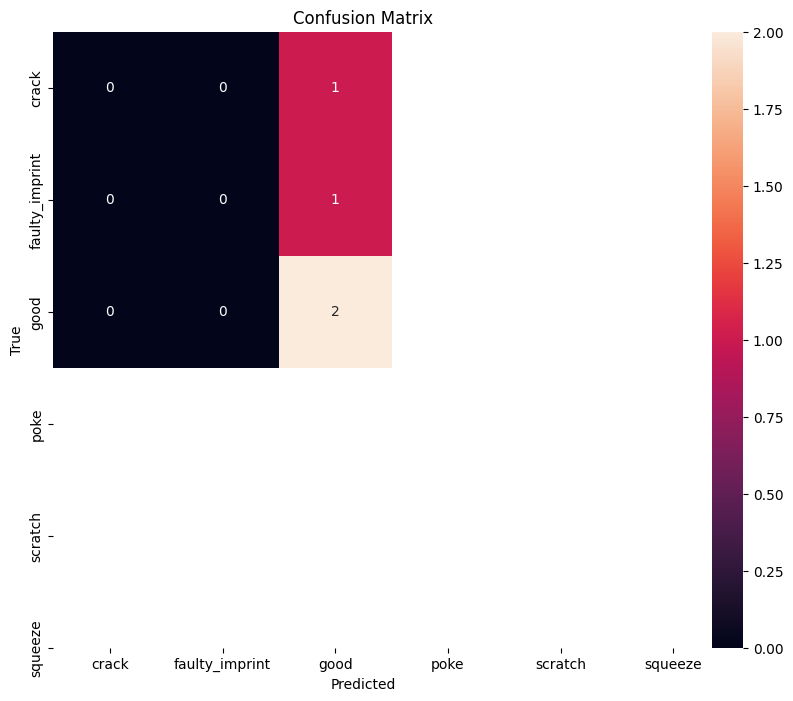

In [8]:
# Confusion Matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Advanced Evaluation
from src.evaluation.benchmark import evaluate_model

print("Evaluating model with advanced metrics...")
results = evaluate_model(model, test_ds)

print("\nEvaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")